# PATH TOWARDS STACKING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [2]:
CLASSIFIERS = {'rdmf': RandomForestClassifier(n_estimators=100, random_state=27, n_jobs=-1),
               'logreg': LogisticRegression(n_jobs=-1)}
               #'xgboost': XGBClassifier(n_estimators=24, learning_rate=0.05, max_depth=3,
                         #               min_child_weight=1, gamma=0,
                           #             scale_pos_weight=1, nthread=-1, seed=27)}

FEATURES_TO_KEEP = {'rdmf': ['h_season_points', 'h_mean_nb_goals_scored_home',
                             'h_mean_nb_goals_conceded_home', 'h_season_wages',
                             'a_mean_nb_goals_scored_away',
                             'a_mean_nb_goals_conceded_away',
                             'a_season_wages', 'distance_km'],
                    'logreg': ['h_nb_games_home', 'h_nb_victories', 'h_season_points',
                               'h_nb_games_total', 'h_nb_goals_scored_home',
                               'h_season_wages', 'a_nb_games_away', 'a_season_points',
                               'a_nb_games_total', 'a_season_wages'],
                    'xgboost': ['h_nb_victories', 'h_season_points',
                                'h_nb_games_total', 'h_nb_goals_scored_home',
                                'h_mean_nb_goals_scored_home', 'h_nb_goals_conceded_home',
                                'h_mean_nb_goals_conceded_home', 'h_season_wages',
                                'a_season_points', 'a_nb_goals_scored_away',
                                'a_mean_nb_goals_scored_away', 'a_mean_nb_goals_conceded_away',
                                'a_season_wages', 'capacity_home_stadium']}

In [3]:
FILEPATH = '../data/ML/E0_ML.csv'
data = pd.read_csv(FILEPATH)
data = data.drop('id', 1)
stacking_data = data.copy()

n_train = int(2*len(stacking_data)/3)
n_test = len(stacking_data) - n_train

stacking_data_train = stacking_data[0:n_train]
stacking_data_train=stacking_data_train.reset_index()

stacking_data_test = stacking_data[n_train:n_train+n_test]
stacking_data_test=stacking_data_test.reset_index()

In [4]:
y = data['home_win'].values

feat_data = data.drop('home_win', 1)


X = feat_data.values
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

X_train = X[0:n_train]
y_train = y[0:n_train]

X_test = X[n_train:n_train+n_test]
y_test = y[n_train:n_train+n_test]

## Step 1: Metadata_train: Create k folds and associate the examples to one fold

In [5]:
stacking_data_train['fold_index']=np.nan
from sklearn.model_selection import StratifiedKFold
k=5
skf = StratifiedKFold(n_splits=k,random_state=17)
i=0
for train_index, test_index in skf.split(X_train, y_train):
    stacking_data_train.loc[test_index,'fold_index'] = i
    i+=1

## Step 2: Metada_train: For all models, train on k-1 folds, predict on the remaining fold

In [6]:
for algo_name in CLASSIFIERS:
    stacking_data_train[algo_name]=np.nan
    algo_proba_name = algo_name+'_proba'
    stacking_data_train[algo_proba_name]=np.nan
    
    classifier = CLASSIFIERS[algo_name]
  
    for train_index, test_index in skf.split(X_train, y_train):
        classifier.fit(X_train[train_index],y_train[train_index])
        probas = classifier.predict_proba(X_train[test_index])
        probas_home_win = [p[1] for p in probas]
        predictions = [1 if p[1] > 0.5 else 0 for p in probas]
        for i in range(len(test_index)):
            stacking_data_train.set_value(test_index[i], algo_name, predictions[i])
            stacking_data_train.set_value(test_index[i],algo_proba_name,probas_home_win[i])
            
stacking_data_train.head()

,index,h_nb_games_home,h_nb_victories,h_season_points,h_nb_games_total,h_last_n_games_points,h_nb_goals_scored_home,h_mean_nb_goals_scored_home,h_nb_goals_conceded_home,h_mean_nb_goals_conceded_home,...,Month,Week,distance_km,capacity_home_stadium,home_win,fold_index,rdmf,rdmf_proba,logreg,logreg_proba
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,33,7839.955337,42785.0,0,0.0,1.0,0.64,1.0,0.524005
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,33,2384.244176,31154.0,0,0.0,0.0,0.43,0.0,0.244210
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,33,8738.109400,28100.0,0,0.0,1.0,0.55,0.0,0.410395
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,33,14384.656594,42449.0,1,0.0,1.0,0.92,1.0,0.724157
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,33,8491.070855,40157.0,0,0.0,1.0,0.57,0.0,0.311122


## Step 3: Train models on entire training database and predict on testing database to create Metadata_test

In [7]:
for algo_name in CLASSIFIERS:
    stacking_data_test[algo_name]=np.nan
    algo_proba_name = algo_name+'_proba'
    stacking_data_test[algo_proba_name]=np.nan
    
    classifier = CLASSIFIERS[algo_name]
    classifier.fit(X_train,y_train)
    probas_test = classifier.predict_proba(X_test)
    probas_home_win_test = [p[1] for p in probas_test]
    predictions_test = [1 if p[1] > 0.5 else 0 for p in probas_test]
    for i in range(len(predictions_test)):
        stacking_data_test.set_value(i,algo_name,predictions_test[i])
        stacking_data_test.set_value(i,algo_proba_name,probas_home_win_test[i])

stacking_data_test.head()

,index,h_nb_games_home,h_nb_victories,h_season_points,h_nb_games_total,h_last_n_games_points,h_nb_goals_scored_home,h_mean_nb_goals_scored_home,h_nb_goals_conceded_home,h_mean_nb_goals_conceded_home,...,a_season_wages,Month,Week,distance_km,capacity_home_stadium,home_win,rdmf,rdmf_proba,logreg,logreg_proba
0,1968,3.0,1.0,8.0,6.0,3.0,4.0,1.333333,4.0,1.333333,...,80.0,10,40,5695.401385,36230.0,1,0.0,0.36,1.0,0.508677
1,1969,3.0,1.0,7.0,6.0,3.0,4.0,1.333333,5.0,1.666667,...,73.0,10,40,554.895194,35303.0,1,0.0,0.46,0.0,0.421646
2,1970,3.0,2.0,13.0,7.0,7.0,6.0,2.000000,1.0,0.333333,...,77.0,10,42,14491.591434,32689.0,1,0.0,0.49,0.0,0.463619
3,1971,3.0,0.0,4.0,7.0,2.0,5.0,1.666667,7.0,2.333333,...,57.0,10,42,15007.135737,52409.0,1,0.0,0.42,0.0,0.474554
4,1972,3.0,1.0,14.0,7.0,4.0,4.0,1.333333,3.0,1.000000,...,101.0,10,42,9694.031967,47405.0,1,1.0,0.54,1.0,0.678147


## Train and predict with a stacking model

In [8]:
train_meta = stacking_data_train[['rdmf','logreg','home_win']]
X_train_meta = train_meta.drop('home_win',1).values
y_train_meta = train_meta['home_win'].values

test_meta = stacking_data_test[['rdmf','logreg','home_win']]
X_test_meta = test_meta.drop('home_win',1).values
y_test_meta = test_meta['home_win'].values

stack_model = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
stack_model.fit(X_train_meta,y_train_meta)
proba_stack = stack_model.predict_proba(X_test_meta)
proba_home_win_stack = [p[1] for p in proba_stack]
predictions_stack = [1 if p[1] > 0.5 else 0 for p in proba_stack]

auc_stack = roc_auc_score(y_test_meta, proba_home_win_stack)
accuracy_stack = accuracy_score(y_test_meta,predictions_stack)
print('AUC with stacking: %f' % auc_stack)
print('accuracy with stacking: %f' % accuracy_stack)

AUC with stacking: 0.628479
accuracy with stacking: 0.618274


## Comparison with initial models

In [9]:
y_train_initial = stacking_data_train['home_win'].values
y_test_initial = stacking_data_test['home_win'].values

X_train_rdmf = stacking_data_train[FEATURES_TO_KEEP['rdmf']].values
X_test_rdmf = stacking_data_test[FEATURES_TO_KEEP['rdmf']].values

X_train_log_reg = stacking_data_train[FEATURES_TO_KEEP['logreg']].values
X_test_log_reg = stacking_data_test[FEATURES_TO_KEEP['logreg']].values

rdmf = CLASSIFIERS['rdmf']
rdmf.fit(X_train_rdmf,y_train_initial)
proba_rdmf = rdmf.predict_proba(X_test_rdmf)
proba_home_win_rdmf = [p[1] for p in proba_rdmf]
predictions_rdmf = [1 if p[1] > 0.5 else 0 for p in proba_rdmf]
auc_rdmf = roc_auc_score(y_test_initial, proba_home_win_rdmf)
accuracy_rdmf = accuracy_score(y_test_initial,predictions_rdmf)
print('AUC random forest: %f' % auc_rdmf)
print('accuracy random forest: %f' % accuracy_rdmf)

logreg = CLASSIFIERS['logreg']
logreg.fit(X_train_log_reg,y_train_initial)
proba_logreg = logreg.predict_proba(X_test_log_reg)
proba_home_win_logreg = [p[1] for p in proba_logreg]
predictions_logreg = [1 if p[1] > 0.5 else 0 for p in proba_logreg]
auc_logreg = roc_auc_score(y_test_initial, proba_home_win_logreg)
accuracy_logreg = accuracy_score(y_test_initial,predictions_logreg)
print('AUC logistic regression: %f' % auc_logreg)
print('accuracy logistic regression: %f' % accuracy_logreg)


AUC random forest: 0.665669
accuracy random forest: 0.635533
AUC logistic regression: 0.668936
accuracy logistic regression: 0.613198


In [10]:
predict_aux_rdmf = stacking_data_test['rdmf'].values
predict_aux_logreg = stacking_data_test['logreg'].values

accuracy_aux_rdmf = accuracy_score(y_test_initial,predict_aux_rdmf)
print(accuracy_aux_rdmf)
accuracy_aux_logreg = accuracy_score(y_test_initial,predict_aux_logreg)
print(accuracy_aux_logreg)

0.62538071066
0.618274111675


In [11]:
predic_dic = {'pred_stack':predictions_stack,
             'pred_rdmf':predict_aux_rdmf,
             'pred_logreg':predict_aux_logreg}
predic_df = pd.DataFrame(predic_dic)
predic_df_1 = predic_df[predic_df['pred_logreg']==predic_df['pred_stack']]
predic_df_2 = predic_df[predic_df['pred_rdmf']==predic_df['pred_stack']]
print(len(predic_df))
print(len(predic_df_1))
print(len(predic_df_2))

985
985
812


In [32]:
proba_rdmf = stacking_data_test['rdmf_proba'].values
proba_logreg = stacking_data_test['logreg_proba'].values
probas_mean = 0.5*proba_rdmf + 0.5*proba_logreg
probas_meth1 = 0.6*proba_rdmf + 0.4*proba_logreg
probas_meth2 = 0.4*proba_rdmf + 0.6*proba_logreg
print(roc_auc_score(y_test_initial, proba_rdmf))
print(roc_auc_score(y_test_initial, proba_logreg))
print('')
print(roc_auc_score(y_test_initial, probas_mean))
print(roc_auc_score(y_test_initial, probas_meth1))
print(roc_auc_score(y_test_initial, probas_meth2))
print('')
probas_meth3 = [0.5*proba_home_win_logreg[i] + 0.5*proba_home_win_rdmf[i] for i in range(len(proba_home_win_logreg))]
print(roc_auc_score(y_test_initial, probas_meth3))

0.667737014499
0.667938613993

0.675798915935
0.675952713488
0.674975891194

0.674871973929


## CV training stacking model

### merge meta_data_train and meta_data_test

In [18]:
meta_data_train = stacking_data_train.drop('fold_index',1)
meta_data_test = stacking_data_test.copy()

frames = [meta_data_train, meta_data_test]
meta_data = pd.concat(frames)
meta_data.head()

1968
985
2953
['index' 'h_nb_games_home' 'h_nb_victories' 'h_season_points'
 'h_nb_games_total' 'h_last_n_games_points' 'h_nb_goals_scored_home'
 'h_mean_nb_goals_scored_home' 'h_nb_goals_conceded_home'
 'h_mean_nb_goals_conceded_home' 'h_season_wages' 'a_nb_games_away'
 'a_nb_victories_draws' 'a_season_points' 'a_nb_games_total'
 'a_last_n_games_points' 'a_nb_goals_scored_away'
 'a_mean_nb_goals_scored_away' 'a_nb_goals_conceded_away'
 'a_mean_nb_goals_conceded_away' 'a_season_wages' 'Month' 'Week'
 'distance_km' 'capacity_home_stadium' 'home_win' 'rdmf' 'rdmf_proba'
 'logreg' 'logreg_proba']
['index' 'h_nb_games_home' 'h_nb_victories' 'h_season_points'
 'h_nb_games_total' 'h_last_n_games_points' 'h_nb_goals_scored_home'
 'h_mean_nb_goals_scored_home' 'h_nb_goals_conceded_home'
 'h_mean_nb_goals_conceded_home' 'h_season_wages' 'a_nb_games_away'
 'a_nb_victories_draws' 'a_season_points' 'a_nb_games_total'
 'a_last_n_games_points' 'a_nb_goals_scored_away'
 'a_mean_nb_goals_scored_away' 

In [19]:
meta_data_predict = meta_data[['rdmf','logreg']]
meta_data_proba = meta_data[['rdmf_proba','logreg_proba']]

y = meta_data['home_win'].values
X_predict = meta_data_predict.values
X_proba = meta_data_proba.values

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

classifier = RandomForestClassifier(n_estimators=500)

proba_from_predict = cross_val_predict(classifier, X_predict, y,
                              method='predict_proba',
                              cv=10, n_jobs=-1)

proba_from_proba = cross_val_predict(classifier, X_proba, y,
                              method='predict_proba',
                              cv=10, n_jobs=-1)

prob_from_pred = [p[1] for p in proba_from_predict]
prob_from_prob = [p[1] for p in proba_from_proba]

auc_proba = roc_auc_score(y, prob_from_prob)
print('proba')
print(auc_proba)

print('')

auc_predict = roc_auc_score(y, prob_from_pred)
print('predict')
print(auc_predict)

proba
0.604781807642

predict
0.638774096419


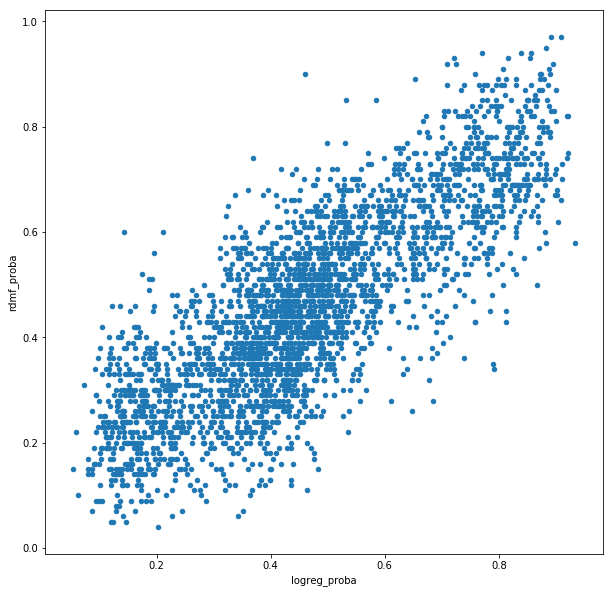

In [30]:
fig,ax=plt.subplots(figsize=(10,10))
meta_data_proba.plot.scatter('logreg_proba','rdmf_proba',ax=ax)
plt.show()